In [1]:
from __future__ import absolute_import, division, print_function
#Encode words
import codecs
#regex-quickly search through files
import glob
#concurrency
import multiprocessing
import os
#pretty printing
import pprint
#regular expressions
import re
#natural language toolkit
import nltk
#word2vec
import gensim.models.word2vec as w2v
#dimensionality reduction - tsne
import sklearn.manifold
import numpy as np
#data visualization
import matplotlib.pyplot as plt
#incase of gensim warning
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning, module='gensim')
#data frame handling
import pandas as pd
#data visualization
import seaborn as sns

E:\Anaconda\lib\site-packages\gensim\utils.py:855: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [2]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Light\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Light\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
book_filenames = sorted(glob.glob("./Books/*.txt"))
print (book_filenames)

["./Books\\(Book 1) Harry Potter And The Sorcerer's Stone.txt", './Books\\(Book 2) Harry Potter And The Chamber Of Secrets.txt', './Books\\(Book 3) Harry Potter And The Prisoner Of Azkaban.txt', './Books\\(Book 4) Harry Potter And The Goblet Of Fire.txt', './Books\\(Book 5) Harry Potter And The Order Of The Phoenix Book.txt', './Books\\(Book 6) Harry Potter And The Half Blood Prince.txt', './Books\\(Book 7) Harry Potter And The Deathly Hallows.txt']


In [4]:
corpus_raw=u""
for book_filename in book_filenames:
    print("Reading '{0}'...".format(book_filename))
    with codecs.open(book_filename, "r","ISO-8859-1") as book_file:
        corpus_raw +=book_file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print()

Reading './Books\(Book 1) Harry Potter And The Sorcerer's Stone.txt'...
Corpus is now 462788 characters long

Reading './Books\(Book 2) Harry Potter And The Chamber Of Secrets.txt'...
Corpus is now 980907 characters long

Reading './Books\(Book 3) Harry Potter And The Prisoner Of Azkaban.txt'...
Corpus is now 1624157 characters long

Reading './Books\(Book 4) Harry Potter And The Goblet Of Fire.txt'...
Corpus is now 2762914 characters long

Reading './Books\(Book 5) Harry Potter And The Order Of The Phoenix Book.txt'...
Corpus is now 4454338 characters long

Reading './Books\(Book 6) Harry Potter And The Half Blood Prince.txt'...
Corpus is now 5488910 characters long

Reading './Books\(Book 7) Harry Potter And The Deathly Hallows.txt'...
Corpus is now 6777172 characters long



In [5]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [6]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [7]:
def sentence_to_wordlist(raw):
    clean = re.sub("[^a-zA-Z]"," ", raw)
    words = clean.split()
    return words

In [8]:
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence)>0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [9]:
print(raw_sentences[5])
print(sentence_to_wordlist(raw_sentences[5]))

The Dursleys had a small son called Dudley and in their
opinion there was no finer boy anywhere.
['The', 'Dursleys', 'had', 'a', 'small', 'son', 'called', 'Dudley', 'and', 'in', 'their', 'opinion', 'there', 'was', 'no', 'finer', 'boy', 'anywhere']


In [10]:
token_count = sum([len(sentence) for sentence in sentences])
print("The corpus contains {0:,}tokens".format(token_count))

The corpus contains 1,145,498tokens


In [11]:
num_features=300
min_word_count = 3
num_workers = multiprocessing.cpu_count()
context_size=7
downsampling = 1e-3
seed = 1

In [12]:
hp2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    size=num_features,
    workers=num_workers,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

In [13]:
hp2vec.build_vocab(sentences)

In [14]:
print("Word2Vec vocabulary length: ",len(hp2vec.wv.vocab))
hp2vec.train(sentences)

Word2Vec vocabulary length:  13389


4341111

In [15]:
if not os.path.exists("trained"):
    os.makedirs("trained")

In [16]:
hp2vec.save(os.path.join("trained","hp2vec.w2v"))

In [17]:
hp2vec = w2v.Word2Vec.load(os.path.join("trained","hp2vec.w2v"))

In [18]:
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)
all_word_vectors_matrix = hp2vec.wv.syn0

In [19]:
points = pd.DataFrame(
    [
        (word,coords[0],coords[1])
        for word, coords in [
            (word, all_word_vectors_matrix[hp2vec.wv.vocab[word].index])
            for word in hp2vec.wv.vocab
        ]
    ],
    columns=["word","x","y"]
)
points.head(20)

,word,x,y
0,Harry,0.187126,0.009928
1,Potter,0.107168,0.034538
2,and,0.140530,-0.087729
3,the,0.109286,0.019665
4,Sorcerer,-0.137089,0.181269
5,s,0.101048,-0.011738
6,Stone,-0.042194,0.267190
7,ONE,-0.131866,-0.053332
8,THE,-0.624093,-0.082578
9,BOY,-0.126215,-0.010836


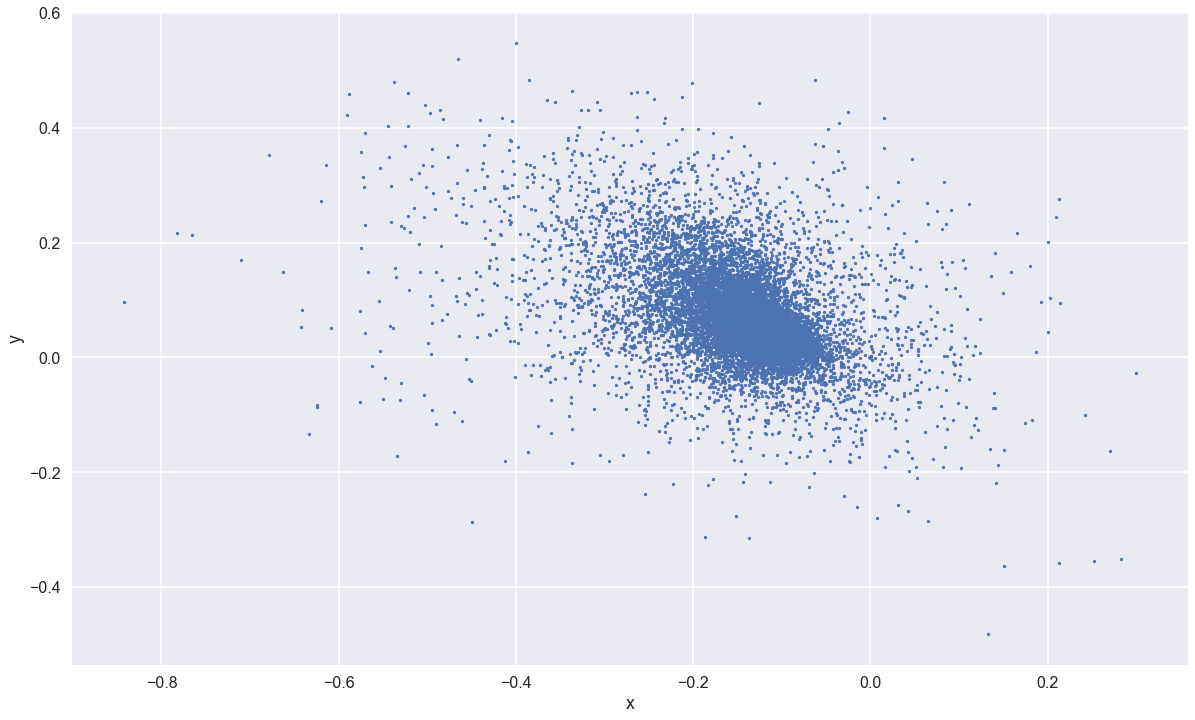

In [20]:
sns.set_context("poster")
%matplotlib inline
points.plot.scatter("x","y", s=8, figsize=(20,12))


In [21]:
def plot_region(x_bounds,y_bounds):
    slice = (points[
        (x_bounds[0] <= points.x) &
        (points.x <= x_bounds[1]) & 
        (y_bounds[0] <= points.y) &
        (points.y <= y_bounds[1])
    ])
    
    slice.x.astype(float)
    slice.y.astype(float)
    ax = slice.plot.scatter("x", "y", s=35, figsize=(10, 8))

    for i, point in slice.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=11)

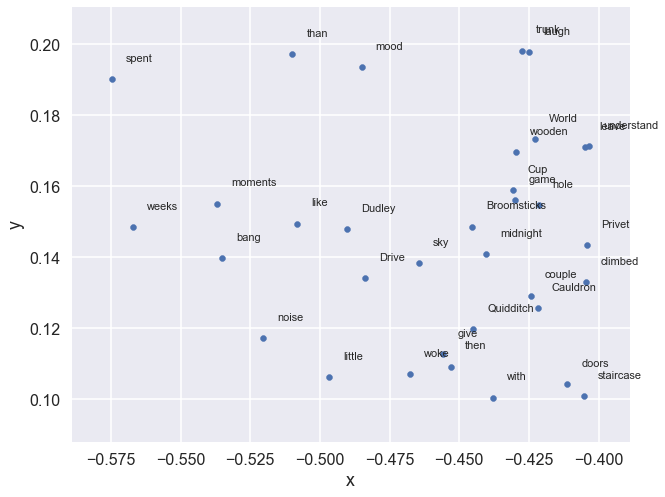

In [39]:

plot_region(x_bounds=(-0.6, -0.4), y_bounds=(0.1, 0.2))

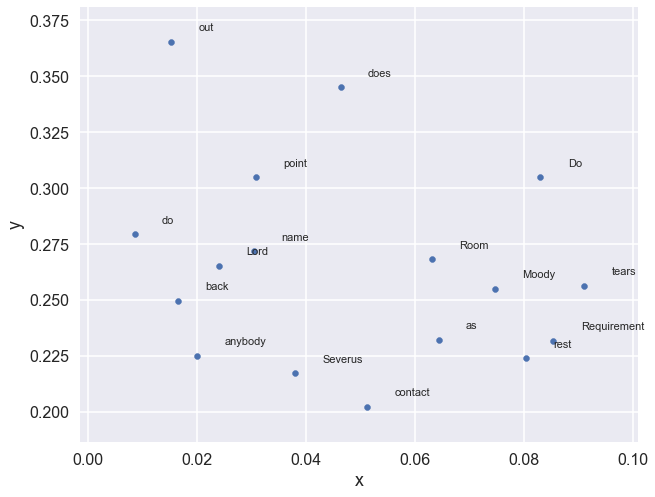

In [38]:
plot_region(x_bounds=(0.0, 0.1), y_bounds=(0.2, 0.4))

In [24]:
hp2vec.most_similar("Gryffindor")

[('Ravenclaw', 0.8101949691772461),
 ('Tower', 0.7753199338912964),
 ('Slytherin', 0.7668248414993286),
 ('Hufflepuff', 0.7429251670837402),
 ('team', 0.7149126529693604),
 ('Flint', 0.6787018775939941),
 ('points', 0.6783568859100342),
 ('goal', 0.6717773079872131),
 ('House', 0.666618287563324),
 ('Chaser', 0.6622005105018616)]

In [25]:
hp2vec.most_similar("scar")

[('forehead', 0.8197072148323059),
 ('seared', 0.7890768647193909),
 ('prickling', 0.7731716632843018),
 ('lightning', 0.7712631225585938),
 ('thoughts', 0.7600809335708618),
 ('prickled', 0.7538779973983765),
 ('insides', 0.7292284965515137),
 ('pain', 0.7256836891174316),
 ('hurting', 0.7163341641426086),
 ('heart', 0.7110214829444885)]

In [26]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = hp2vec.wv.most_similar_cosmul(
        positive=[end2, start1],
        negative=[end1]
    )
    start2 = similarities[0][0]
    print("{start1} is related to {end1}, as {start2} is related to {end2}".format(**locals()))
    return start2

In [27]:
nearest_similarity_cosmul("Kreacher","Black","Harry")

Kreacher is related to Black, as Dobby is related to Harry


'Dobby'

In [28]:
nearest_similarity_cosmul("Ron","keeper","Gryffindor")

Ron is related to keeper, as Wood is related to Gryffindor


'Wood'